In [152]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model 

# from tensorflow.keras.optimizers.legacy import RMSprop

# from tensorflow.keras.optimizers.legacy import Adam

import random

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

In [153]:
file_dir = '/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/uae_nrel_data.csv'
# output_folder = 'assets/arch'
# os.makedirs(output_folder, exist_ok=True)

year=2022

time_step = 24
num_feats = 5
evaluation_results = []

neurons = 500
epochs = 20
batch_size = 64

In [154]:
# Modified evaluate_model function to store results in evaluation_results
def minmaxscaling():
    input_scaler = MinMaxScaler()
    output_scaler = MinMaxScaler()
    return input_scaler, output_scaler

def minmaxscaling_feature_range():
    input_scaler = MinMaxScaler(feature_range = (0,1))
    output_scaler = MinMaxScaler(feature_range = (0,1))
    return input_scaler, output_scaler

def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Step 4: Prepare data for BiLSTM
# def create_dataset(dataset, time_step):
#     print(f'dataset shape {dataset.shape}')
#     dataX, dataY = [], []
#     for i in range(len(dataset) - time_step):
#         a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
#         dataX.append(a)
#         dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
#     return np.array(dataX), np.array(dataY)

def create_dataset (X, y, time_steps):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)

def build_bilstm_model(time_step):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(time_step, num_feats))))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(1)) # output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_learning_curve(history, model_name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve: {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  save_path = os.path.join('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate', f'{model_name}_learning_curve.png')
  plt.savefig(save_path)
  print(f'plot saved to {save_path}')
  plt.show()
  plt.close()


def read_data():
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
#   year = 2022
  data_2022 = data[data.index.year == year]
  data = data_2022[data_2022.index.month == 6]
  return data

In [155]:
data = read_data()

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_33199/966114720.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


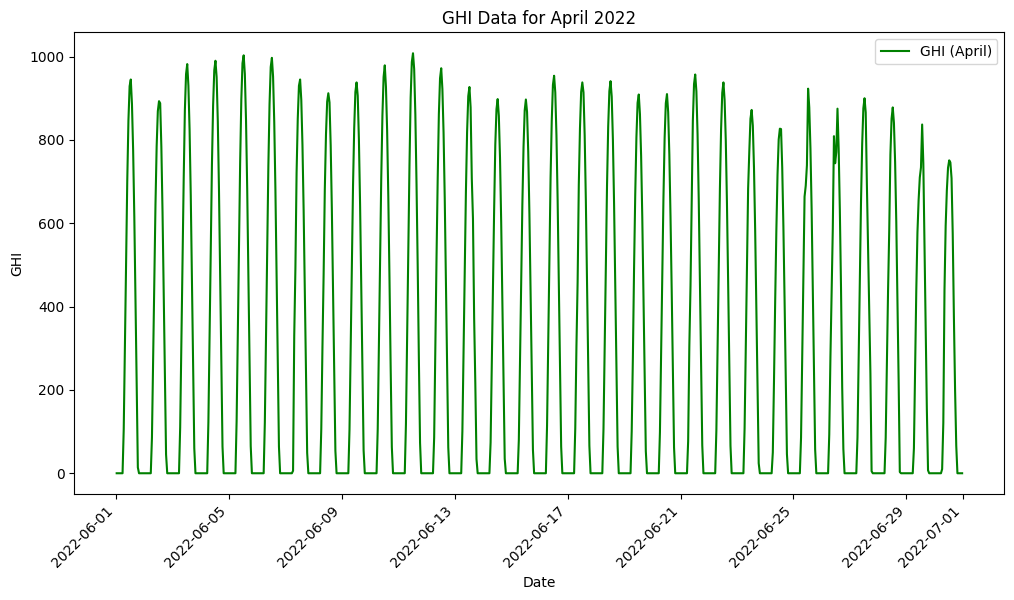

In [156]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['GHI'], label='GHI (April)', color='green')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('GHI')
plt.title(f'GHI Data for April {year}')
plt.legend()
plt.show()

In [157]:
# data = data[(data.index.year == year)]

# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
# dataset = data[['GHI']]

dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

In [158]:
dataset.head()

,Temperature,GHI,Pressure,Wind Speed
Datetime,,,,
2022-06-01 00:30:00,27.3,0,1002,1.4
2022-06-01 01:30:00,27.1,0,1001,1.2
2022-06-01 02:30:00,27.2,0,1001,1.1
2022-06-01 03:30:00,27.3,0,1002,1.3
2022-06-01 04:30:00,27.3,0,1002,1.6


### BiLSTM

In [159]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

Dimension of train data:  (576, 4)
Dimension of test data:  (144, 4)


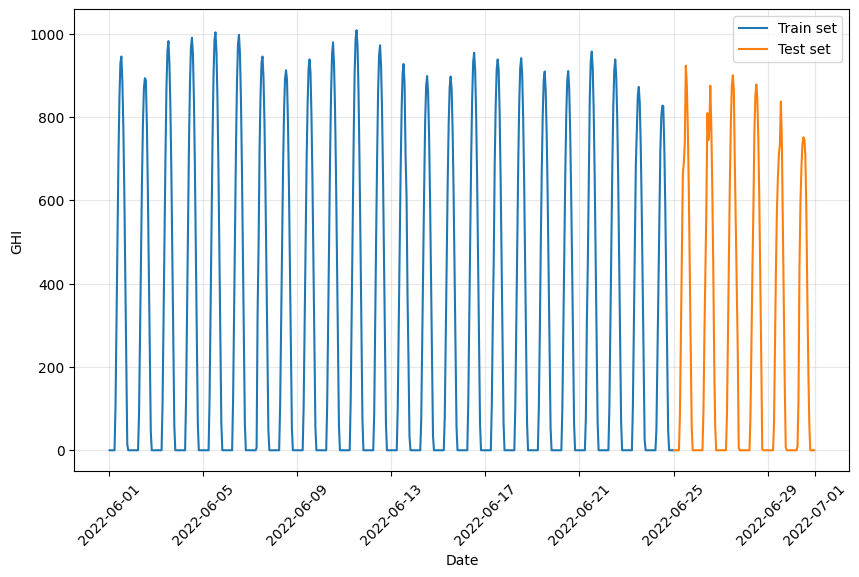

In [160]:
# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.GHI)
plt.plot(test_dataset.GHI)
plt.grid(alpha=0.3)
plt.xlabel('Date')
plt.ylabel('GHI')
plt.legend(['Train set', 'Test set'], loc='upper right')
plt.xticks(rotation=45)

#plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/2.jpg', format='jpg', dpi=1000)

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [161]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [162]:
# scaler_x = MinMaxScaler(feature_range = (0,1))
# scaler_y = MinMaxScaler(feature_range = (0,1))

# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()

scaler_x, scaler_y = minmaxscaling()

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_trainy)
output_scaler = scaler_y.fit(y_trainy)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_trainy)
train_x_norm = input_scaler.transform(X_trainy)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_testy)
test_x_norm = input_scaler.transform(X_testy)

In [163]:
# def create_dataset (X, y, time_steps):
#     Xs, ys = [], []
    
#     for i in range(len(X)-time_steps):
#         v = X[i:i+time_steps, :]
#         Xs.append(v)
#         ys.append(y[i+time_steps])
        
#     return np.array(Xs), np.array(ys)


TIME_STEPS = 24

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (120, 24, 3)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 3)
y_test.shape:  (552, 1)


In [166]:
# model = build_bilstm_model(time_step)

model = Sequential()
model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=True, input_shape=(time_step, num_feats))))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=False)))
model.add(Dropout(0.1))
model.add(Dense(1)) # output layer
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [167]:
history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
9/9 [==============================] - 5s 378ms/step - loss: 0.1656 - val_loss: 0.1048
Epoch 2/20
9/9 [==============================] - 3s 325ms/step - loss: 0.1147 - val_loss: 0.0732
Epoch 3/20
9/9 [==============================] - 3s 311ms/step - loss: 0.0739 - val_loss: 0.0250
Epoch 4/20
9/9 [==============================] - 3s 322ms/step - loss: 0.0270 - val_loss: 0.0195
Epoch 5/20
9/9 [==============================] - 4s 405ms/step - loss: 0.0233 - val_loss: 0.0113
Epoch 6/20
9/9 [==============================] - 3s 349ms/step - loss: 0.0134 - val_loss: 0.0076
Epoch 7/20
9/9 [==============================] - 3s 314ms/step - loss: 0.0074 - val_loss: 0.0050
Epoch 8/20
9/9 [==============================] - 3s 317ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 9/20
9/9 [==============================] - 3s 311ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 10/20
9/9 [==============================] - 3s 324ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 11/20
9/9 [==

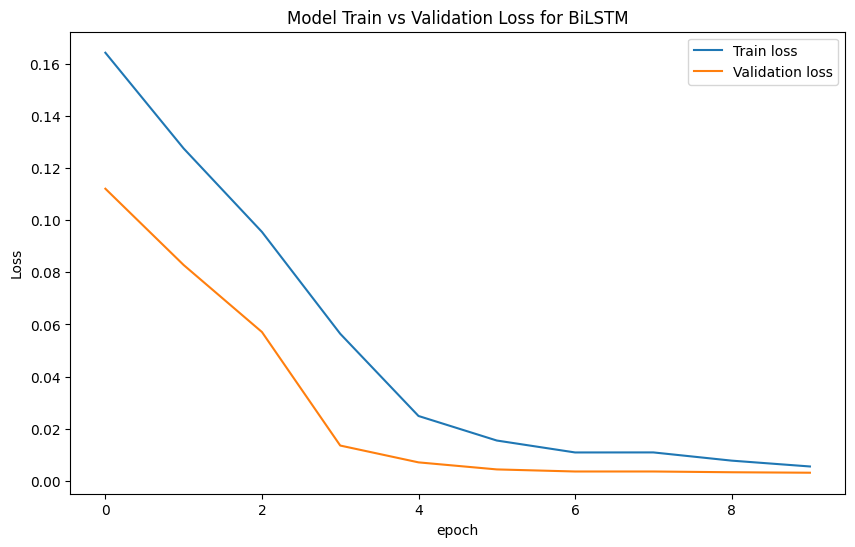

In [61]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history, 'BiLSTM')

In [62]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [63]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model)

4/4 [==============================] - 1s 104ms/step


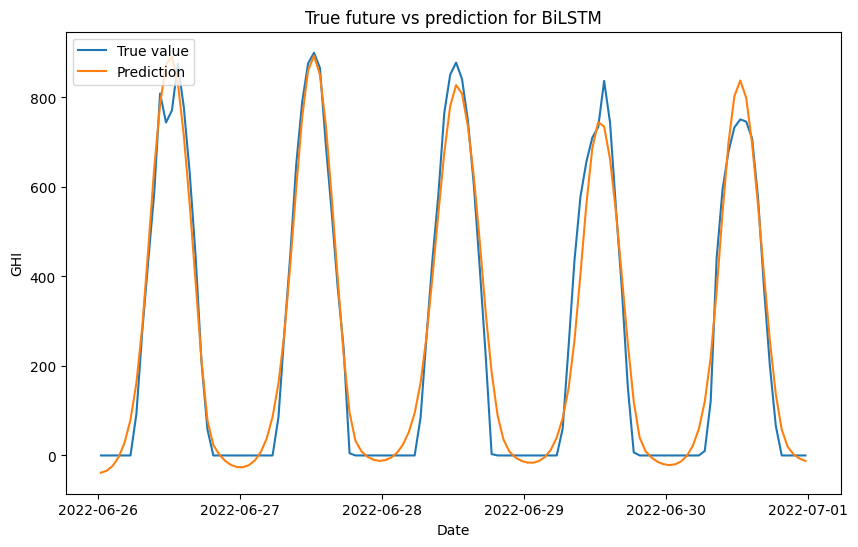

In [64]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    prediction_index = dataset.index[-range_future:]  

    plt.plot(prediction_index, np.array(y_test), label='True value')
    plt.plot(prediction_index, np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)

In [65]:
def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

In [66]:
evaluate_model(y_test, prediction_bilstm, 'BiLSTM', 'Testing')

In [67]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Testing,41.51547,3216.695784,56.715922,0.968936


### GBDT-BiLSTM

In [68]:

data = read_data()


# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_33199/966114720.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [69]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]


In [70]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [71]:
# X = dataset.iloc[:, 1:].values  # Features
# y = dataset.iloc[:, 0].values   # Target

# train_size = int(len(X) * 0.8)
# test_size = len(X) - train_size
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [72]:
# Step 1: Train GBDT, XGB, and CatBoost on the training data
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

gbdt.fit(X_trainy, y_trainy)

# Step 2: Get predictions for all models on both training and test sets
gbdt_output_train = gbdt.predict(X_trainy)
gbdt_output_test = gbdt.predict(X_testy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


In [73]:
# input_scaler = MinMaxScaler(feature_range = (0,1))
# output_scaler = MinMaxScaler(feature_range = (0,1))

# input_scaler = MinMaxScaler()
# output_scaler = MinMaxScaler()

input_scaler, output_scaler = minmaxscaling()

input_scaler.fit(gbdt_output_train.reshape(-1, 1))
# output_scaler.fit(gbdt_output_train.reshape(-1, 1))


train_x_norm = input_scaler.transform(gbdt_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(gbdt_output_test.reshape(-1, 1))


In [74]:

output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)


In [75]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (552, 24, 3)
y_train.shape: (552, 1)
X_test.shape: (120, 24, 3)
y_test.shape: (120, 1)


In [76]:
# input_scaler = scaler_x.fit(gbdt_output_train.reshape(-1, 1))
# output_scaler = scaler_y.fit(gbdt_output_test.reshape(-1, 1))

# # Apply the scaler to training data
# # train_y_norm = output_scaler.transform(y_trainy)
# train_x_norm = input_scaler.transform(gbdt_output_test.reshape(-1, 1))

# # Apply the scaler to test data
# # test_y_norm = output_scaler.transform(y_testy)
# test_y_norm = input_scaler.transform(gbdt_output_test.reshape(-1, 1))

In [77]:
# def create_dataset (X, y, time_steps = 1):
#     Xs, ys = [], []
    
#     for i in range(len(X)-time_steps):
#         v = X[i:i+time_steps, :]
#         Xs.append(v)
#         ys.append(y[i+time_steps])
        
#     return np.array(Xs), np.array(ys)


# TIME_STEPS = 24

# X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)

TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


### BiLSTM component

In [78]:
model = build_bilstm_model(time_step)

In [79]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
9/9 [==============================] - 10s 751ms/step - loss: 0.1460 - val_loss: 0.0940
Epoch 2/20
9/9 [==============================] - 6s 697ms/step - loss: 0.0871 - val_loss: 0.0319
Epoch 3/20
9/9 [==============================] - 6s 663ms/step - loss: 0.0272 - val_loss: 0.0081
Epoch 4/20
9/9 [==============================] - 6s 707ms/step - loss: 0.0131 - val_loss: 0.0047
Epoch 5/20
9/9 [==============================] - 7s 742ms/step - loss: 0.0107 - val_loss: 0.0094
Epoch 6/20
9/9 [==============================] - 6s 721ms/step - loss: 0.0102 - val_loss: 0.0064
Epoch 7/20
9/9 [==============================] - 6s 705ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 8/20
9/9 [==============================] - 7s 737ms/step - loss: 0.0080 - val_loss: 0.0055
Epoch 9/20
9/9 [==============================] - 6s 671ms/step - loss: 0.0068 - val_loss: 0.0081
Epoch 10/20
9/9 [==============================] - 6s 637ms/step - loss: 0.0077 - val_loss: 0.0102
Epoch 11/20
9/9 [=

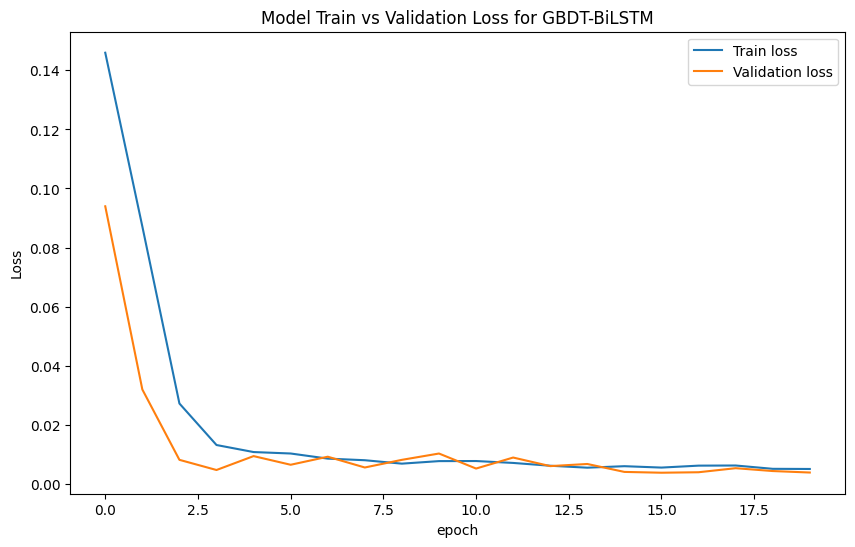

In [80]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history, 'GBDT-BiLSTM')

In [81]:
# Note that I have to use scaler_y
y_test = output_scaler.inverse_transform(y_test)
y_train = output_scaler.inverse_transform(y_train)

In [82]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_gbdt_bilstm = prediction(model)

4/4 [==============================] - 1s 122ms/step


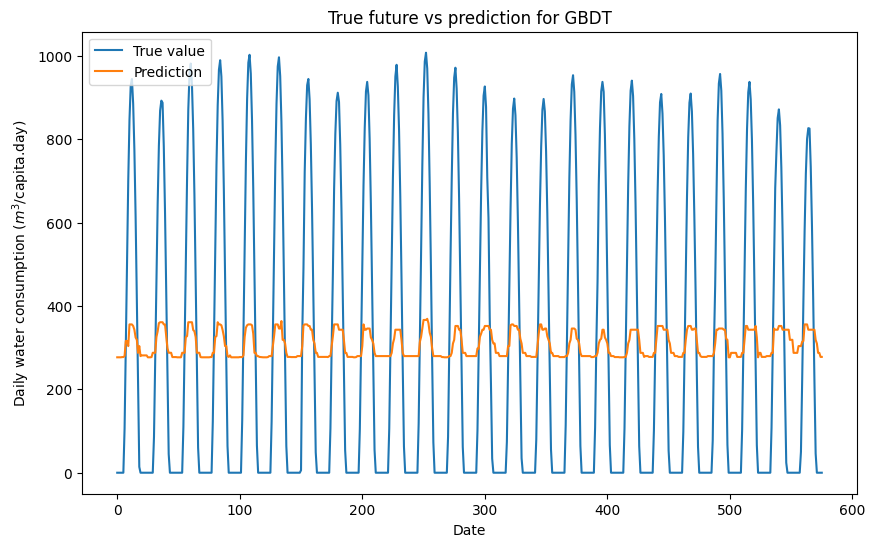

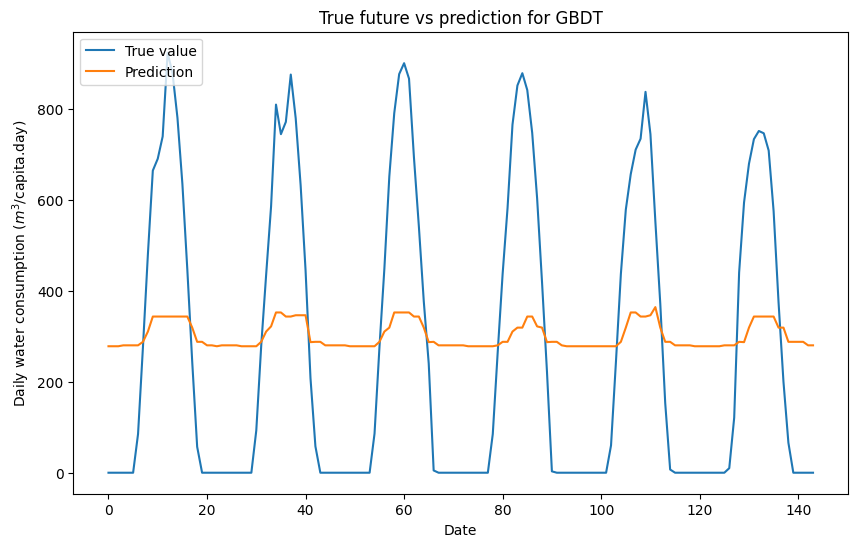

In [83]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
    
    
plot_future(gbdt_output_train, 'GBDT', y_trainy)
plot_future(gbdt_output_test, 'GBDT', y_testy)

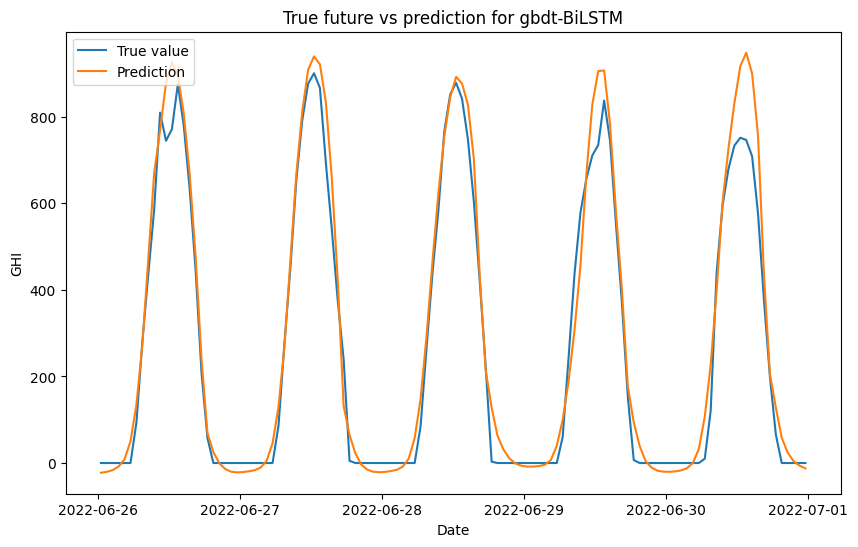

In [84]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    prediction_index = dataset.index[-range_future:]  

    plt.plot(prediction_index, np.array(y_test), label='True value')
    plt.plot(prediction_index, np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_gbdt_bilstm, 'gbdt-BiLSTM', y_test)

In [85]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, gbdt_output_train, 'gbdt', 'Training')
evaluate_model(y_testy, gbdt_output_test, 'gbdt', 'Testing')

In [86]:
# Evaluate model performance on training and test sets
evaluate_model(y_test, prediction_gbdt_bilstm, 'GBDT-BiLSTM', 'Testing')
# evaluate_model(y_testy, gbdt_output_test, 'GBDT', 'Testing')

In [87]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'GBDT-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
3,GBDT-BiLSTM,Testing,42.611347,3855.923193,62.09608,0.962763


In [88]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'GBDT-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
3,GBDT-BiLSTM,Testing,42.611347,3855.923193,62.09608,0.962763


## catboost-bilstm

In [89]:

data = read_data()


# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_33199/966114720.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [90]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [91]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [92]:
catboost = CatBoostRegressor(n_estimators=100, learning_rate=0.001, depth=5, verbose=0)

catboost.fit(X_trainy, y_trainy)

In [93]:
catboost_output_train = catboost.predict(X_trainy)
catboost_output_test = catboost.predict(X_testy)

In [94]:
# input_scaler = MinMaxScaler(feature_range = (0,1))
# output_scaler = MinMaxScaler(feature_range = (0,1))

# input_scaler = MinMaxScaler()
# output_scaler = MinMaxScaler()

# input_scaler, output_scaler = minmaxscaling()

input_scaler.fit(catboost_output_train.reshape(-1, 1))
# output_scaler.fit(catboost_output_test.reshape(-1, 1))

train_x_norm = input_scaler.transform(catboost_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(catboost_output_test.reshape(-1, 1))


In [95]:

output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)

In [96]:
# def create_dataset (X, y, time_steps = 1):
#     Xs, ys = [], []
    
#     for i in range(len(X)-time_steps):
#         v = X[i:i+time_steps, :]
#         Xs.append(v)
#         ys.append(y[i+time_steps])
        
#     return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


BiLSTM component

In [97]:
model = build_bilstm_model(time_step)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
9/9 [==============================] - 9s 682ms/step - loss: 0.1158 - val_loss: 0.0334
Epoch 2/20
9/9 [==============================] - 6s 620ms/step - loss: 0.0289 - val_loss: 0.0099
Epoch 3/20
9/9 [==============================] - 6s 652ms/step - loss: 0.0151 - val_loss: 0.0075
Epoch 4/20
9/9 [==============================] - 6s 710ms/step - loss: 0.0104 - val_loss: 0.0130
Epoch 5/20
9/9 [==============================] - 8s 879ms/step - loss: 0.0081 - val_loss: 0.0068
Epoch 6/20
9/9 [==============================] - 6s 693ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 7/20
9/9 [==============================] - 6s 673ms/step - loss: 0.0067 - val_loss: 0.0127
Epoch 8/20
9/9 [==============================] - 6s 718ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 9/20
9/9 [==============================] - 6s 652ms/step - loss: 0.0056 - val_loss: 0.0080
Epoch 10/20
9/9 [==============================] - 6s 669ms/step - loss: 0.0051 - val_loss: 0.0092
Epoch 11/20
9/9 [==

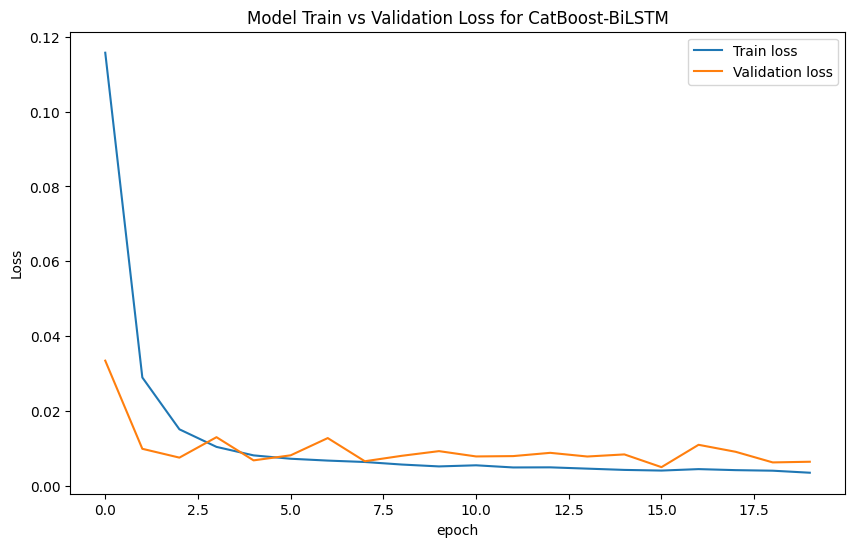

In [98]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history, 'CatBoost-BiLSTM')

In [99]:
def predict_day_ahead(model, last_known_sequence, time_step, scaler, steps_ahead=24):
    predictions = []
    
    # Predict step by step for the next 24 hours (steps_ahead)
    for _ in range(steps_ahead):
        # Reshape the last known sequence into the correct shape for the model (samples, time steps, features)
        last_known_sequence = last_known_sequence.reshape(1, time_step, 1)
        
        # Get the model's prediction (next time step)
        prediction = model.predict(last_known_sequence)
        
        # Inverse transform the prediction to get the original scale
        prediction = scaler.inverse_transform(prediction)
        
        # Store the prediction
        predictions.append(prediction[0, 0])  # Assuming the output is 1D (single value per prediction)
        
        # Update the last_known_sequence by appending the predicted value
        # Shift the sequence for the next prediction
        last_known_sequence = np.append(last_known_sequence[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)
    
    return np.array(predictions)

In [100]:
X_test[-1]

array([[0.01873683],
       [0.02210929],
       [0.018972  ],
       [0.0251019 ],
       [0.02709876],
       [0.02420506],
       [0.02504872],
       [0.03094034],
       [0.06417337],
       [0.15114702],
       [0.64835247],
       [0.81080576],
       [0.85235089],
       [0.83472533],
       [0.80778939],
       [0.79424702],
       [0.78456461],
       [0.75117959],
       [0.65705627],
       [0.27983587],
       [0.12621464],
       [0.10278387],
       [0.08070283],
       [0.05642733]])

In [101]:
last_known_sequence = X_test[-1]  # Get the last sequence from the test set

In [102]:
last_known_sequence.shape

(24, 1)

In [103]:
# Assuming you want to predict for one day ahead from the last known data in the test set


# Predict the day-ahead values (24 hours ahead)
predicted_values = predict_day_ahead(model, last_known_sequence, 24, output_scaler)



1/1 [==============================] - 0s 33ms/step


In [104]:
# Create a time range for the next 24 hours (hourly interval)
# last_timestamp = X_test[-1][0, -1]  # Assuming the timestamp is the first value in the last known sequence
last_timestamp = dataset.index[-1]
# last_timestamp = dataset['Datetime'].iloc[-1]
# last_timestamp = pd.to_datetime(last_timestamp)  # Convert to a pandas datetime object

In [105]:
# last_timestamp = pd.to_datetime(last_timestamp)  # Convert it to a pandas datetime object
print(f"Last timestamp: {last_timestamp}")

time_range = pd.date_range(last_timestamp, periods=25, freq='H')[1:]


Last timestamp: 2022-06-30 23:30:00


/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_33199/1323097987.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(last_timestamp, periods=25, freq='H')[1:]


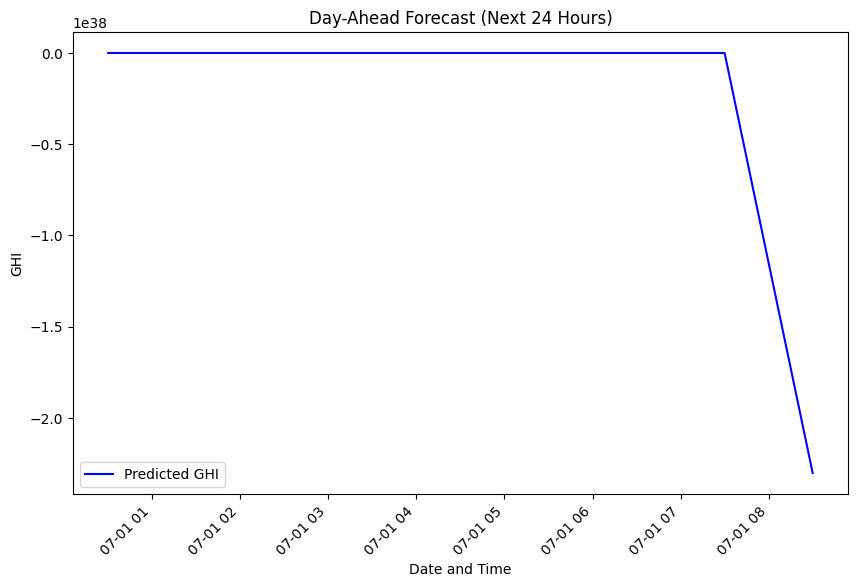

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(time_range, predicted_values.flatten(), label='Predicted GHI', color='blue')  # Flatten to make it 1D
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date and Time')
plt.ylabel('GHI')
plt.title('Day-Ahead Forecast (Next 24 Hours)')

plt.legend()
plt.show()

In [107]:
# Note that I have to use scaler_y
y_test = output_scaler.inverse_transform(y_test)
y_train = output_scaler.inverse_transform(y_train)

In [108]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_cb_bilstm = prediction(model)

4/4 [==============================] - 1s 164ms/step


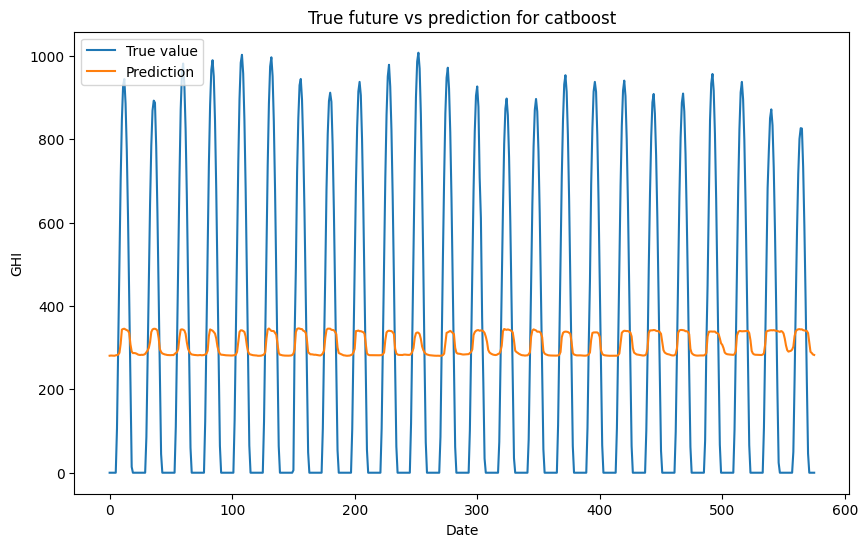

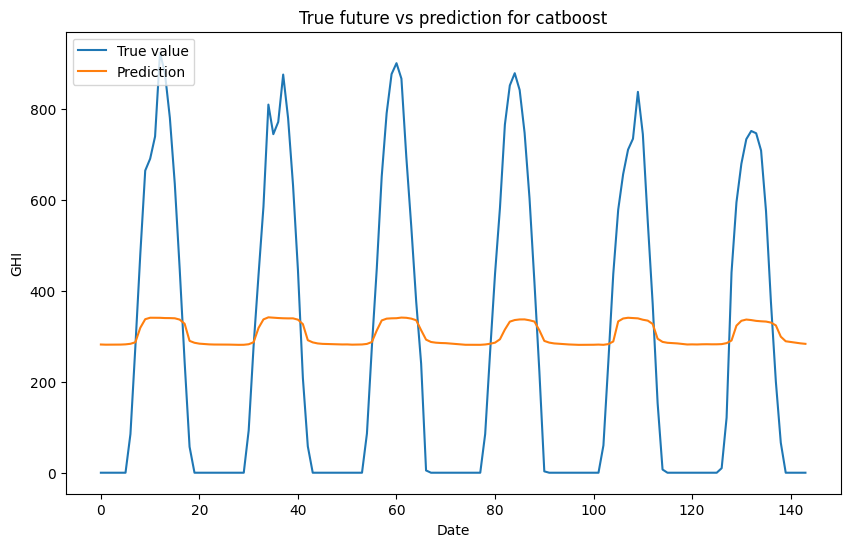

In [109]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
plot_future(catboost_output_train, 'catboost', y_trainy)
plot_future(catboost_output_test, 'catboost', y_testy)

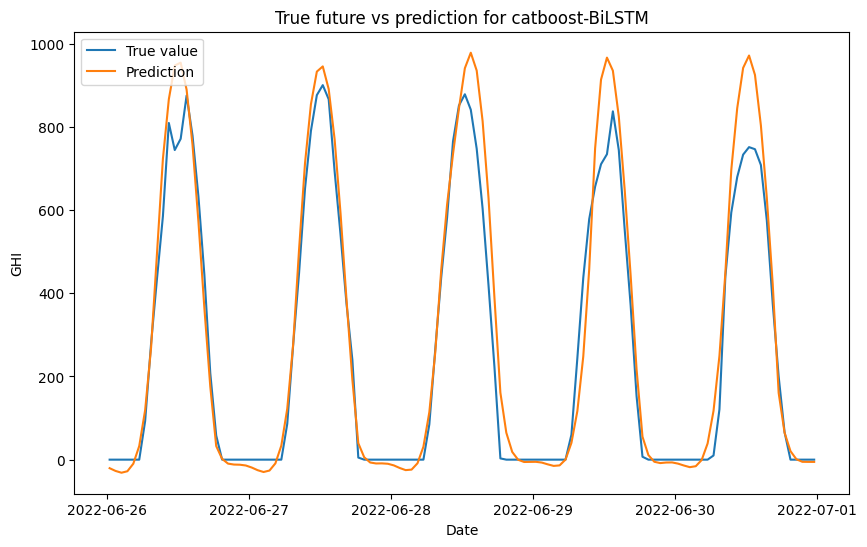

In [110]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    prediction_index = dataset.index[-range_future:]  

    plt.plot(prediction_index, np.array(y_test), label='True value')
    plt.plot(prediction_index, np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_cb_bilstm, 'catboost-BiLSTM', y_test)

In [111]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, catboost_output_train, 'CatBoost', 'Training')
evaluate_model(y_testy, catboost_output_test, 'CatBoost', 'Testing')

In [112]:
evaluate_model(y_test, prediction_cb_bilstm, 'CatBoost-BiLSTM', 'Testing')


In [113]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'CatBoost-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
6,CatBoost-BiLSTM,Testing,52.974865,6493.464605,80.582036,0.937292


## xgb-bilstm

In [114]:

data = read_data()


# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_33199/966114720.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [115]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [116]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [117]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

xgb.fit(X_trainy, y_trainy)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [118]:
xgb_output_train = xgb.predict(X_trainy)
xgb_output_test = xgb.predict(X_testy)

In [119]:
# input_scaler = MinMaxScaler(feature_range = (0,1))
# output_scaler = MinMaxScaler(feature_range = (0,1))

# input_scaler = MinMaxScaler()
# output_scaler = MinMaxScaler()

# input_scaler, output_scaler = minmaxscaling()

input_scaler.fit(xgb_output_train.reshape(-1, 1))
# output_scaler.fit(xgb_output_test.reshape(-1, 1))

train_x_norm = input_scaler.transform(xgb_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(xgb_output_test.reshape(-1, 1))


In [120]:

output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)

In [121]:
# def create_dataset (X, y, time_steps = 1):
#     Xs, ys = [], []
    
#     for i in range(len(X)-time_steps):
#         v = X[i:i+time_steps, :]
#         Xs.append(v)
#         ys.append(y[i+time_steps])
        
#     return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


In [122]:
model = build_bilstm_model(time_step)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
9/9 [==============================] - 11s 681ms/step - loss: 0.1059 - val_loss: 0.0246
Epoch 2/20
9/9 [==============================] - 6s 649ms/step - loss: 0.0191 - val_loss: 0.0097
Epoch 3/20
9/9 [==============================] - 7s 818ms/step - loss: 0.0112 - val_loss: 0.0061
Epoch 4/20
9/9 [==============================] - 7s 840ms/step - loss: 0.0086 - val_loss: 0.0097
Epoch 5/20
9/9 [==============================] - 7s 776ms/step - loss: 0.0081 - val_loss: 0.0146
Epoch 6/20
9/9 [==============================] - 8s 905ms/step - loss: 0.0079 - val_loss: 0.0102
Epoch 7/20
9/9 [==============================] - 7s 803ms/step - loss: 0.0089 - val_loss: 0.0060
Epoch 8/20
9/9 [==============================] - 7s 730ms/step - loss: 0.0076 - val_loss: 0.0094
Epoch 9/20
9/9 [==============================] - 7s 782ms/step - loss: 0.0070 - val_loss: 0.0110
Epoch 10/20
9/9 [==============================] - 7s 747ms/step - loss: 0.0070 - val_loss: 0.0086
Epoch 11/20
9/9 [=

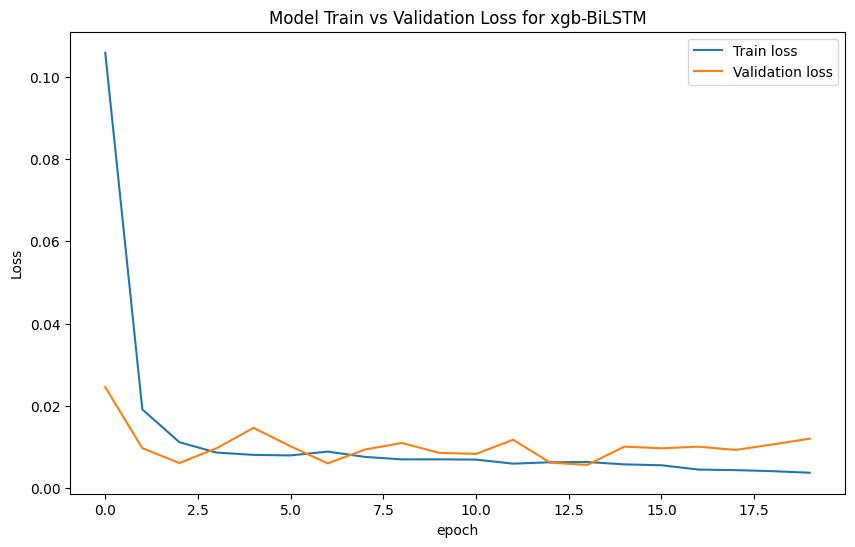

In [123]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history, 'xgb-BiLSTM')

In [124]:
# Note that I have to use scaler_y
y_test = output_scaler.inverse_transform(y_test)
y_train = output_scaler.inverse_transform(y_train)

In [125]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_xgb_bilstm = prediction(model)

4/4 [==============================] - 0s 61ms/step


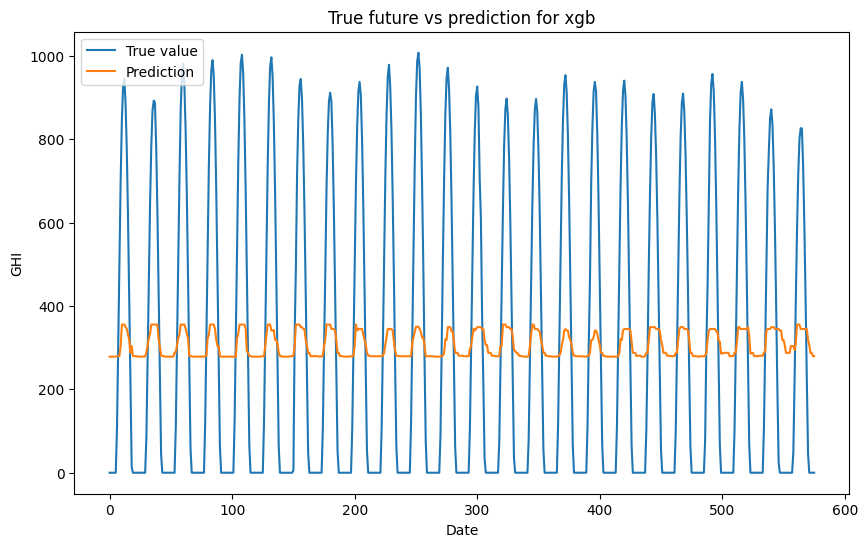

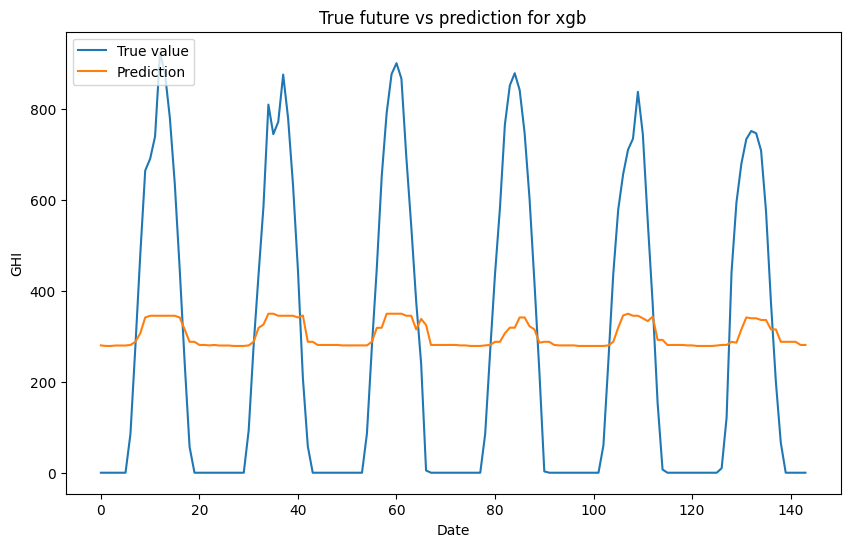

In [126]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
plot_future(xgb_output_train, 'xgb', y_trainy)
plot_future(xgb_output_test, 'xgb', y_testy)

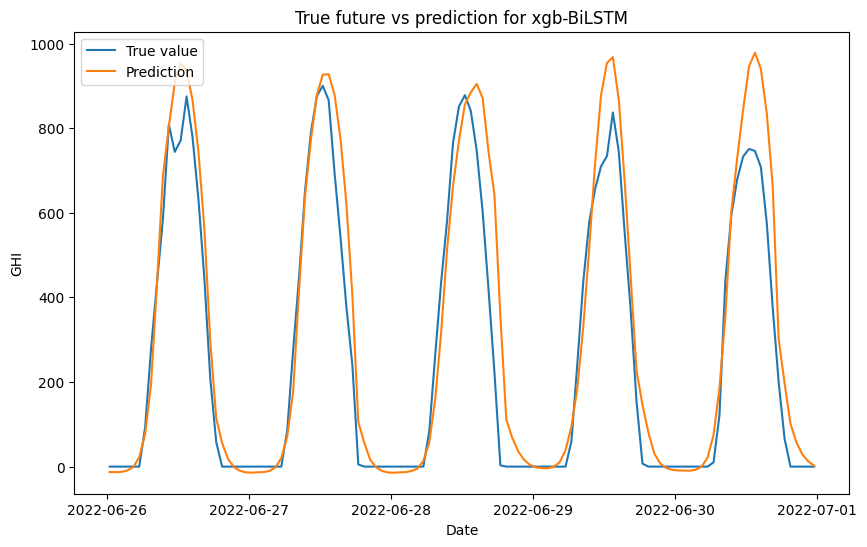

In [127]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    prediction_index = dataset.index[-range_future:]  

    plt.plot(prediction_index, np.array(y_test), label='True value')
    plt.plot(prediction_index, np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_xgb_bilstm, 'xgb-BiLSTM', y_test)

In [128]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, xgb_output_train, 'xgb', 'Training')
evaluate_model(y_testy, xgb_output_test, 'xgb', 'Testing')

In [129]:
evaluate_model(y_test, prediction_xgb_bilstm, 'xgb-BiLSTM', 'Testing')

In [130]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'xgb-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
9,xgb-BiLSTM,Testing,72.138793,12218.221126,110.536063,0.882007


## lightgbm-bilstm

In [131]:
data = read_data()


# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_33199/966114720.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [132]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [133]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [134]:
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.001, max_depth=5, verbosity=-1)
lgbm.fit(X_trainy, y_trainy)

LGBMRegressor(learning_rate=0.001, max_depth=5, verbosity=-1)

In [135]:
lgbm_output_train = lgbm.predict(X_trainy)
lgbm_output_test = lgbm.predict(X_testy)

In [136]:
# input_scaler = MinMaxScaler(feature_range = (0,1))
# output_scaler = MinMaxScaler(feature_range = (0,1))

# input_scaler = MinMaxScaler()
# output_scaler = MinMaxScaler()

input_scaler, output_scaler = minmaxscaling()

input_scaler.fit(lgbm_output_train.reshape(-1, 1))
# output_scaler.fit(lgbm_output_test.reshape(-1, 1))

train_x_norm = input_scaler.transform(lgbm_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(lgbm_output_test.reshape(-1, 1))


In [137]:

output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)

In [138]:
# def create_dataset (X, y, time_steps = 1):
#     Xs, ys = [], []
    
#     for i in range(len(X)-time_steps):
#         v = X[i:i+time_steps, :]
#         Xs.append(v)
#         ys.append(y[i+time_steps])
        
#     return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


In [139]:
model = build_bilstm_model(time_step)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
9/9 [==============================] - 5s 377ms/step - loss: 0.1126 - val_loss: 0.0259
Epoch 2/20
9/9 [==============================] - 3s 365ms/step - loss: 0.0251 - val_loss: 0.0094
Epoch 3/20
9/9 [==============================] - 4s 409ms/step - loss: 0.0143 - val_loss: 0.0086
Epoch 4/20
9/9 [==============================] - 3s 342ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 5/20
9/9 [==============================] - 3s 353ms/step - loss: 0.0098 - val_loss: 0.0103
Epoch 6/20
9/9 [==============================] - 3s 342ms/step - loss: 0.0095 - val_loss: 0.0069
Epoch 7/20
9/9 [==============================] - 4s 422ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 8/20
9/9 [==============================] - 3s 340ms/step - loss: 0.0070 - val_loss: 0.0109
Epoch 9/20
9/9 [==============================] - 3s 327ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 10/20
9/9 [==============================] - 3s 320ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 11/20
9/9 [==

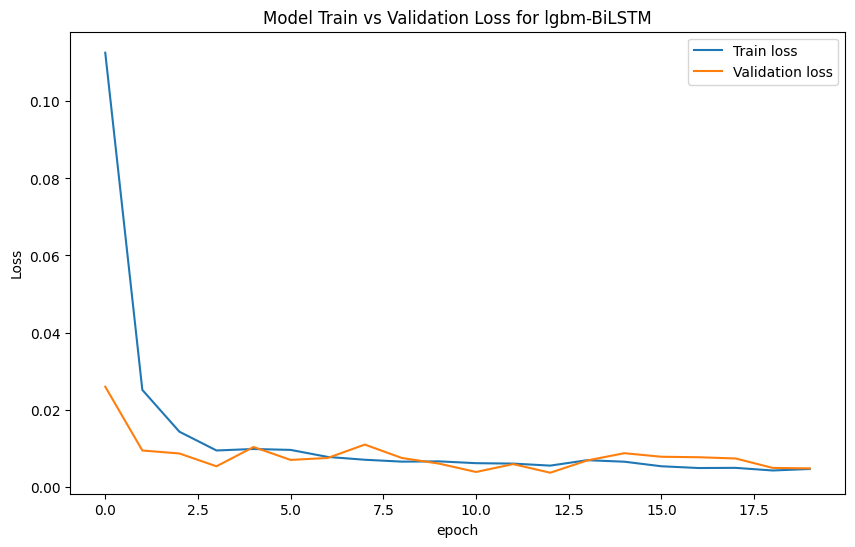

In [140]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history, 'lgbm-BiLSTM')

In [141]:
# Note that I have to use scaler_y
y_test = output_scaler.inverse_transform(y_test)
y_train = output_scaler.inverse_transform(y_train)

In [142]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_lgbm_bilstm = prediction(model)

4/4 [==============================] - 0s 54ms/step


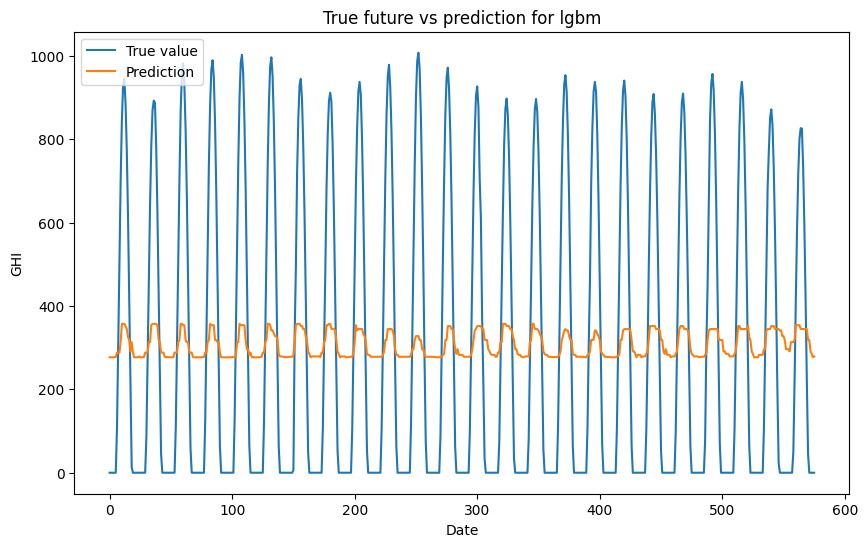

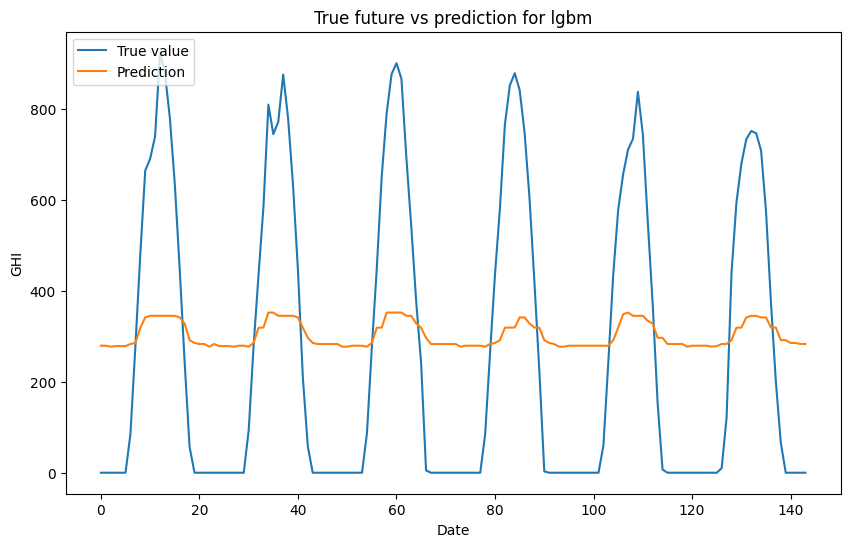

In [143]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
plot_future(lgbm_output_train, 'lgbm', y_trainy)
plot_future(lgbm_output_test, 'lgbm', y_testy)

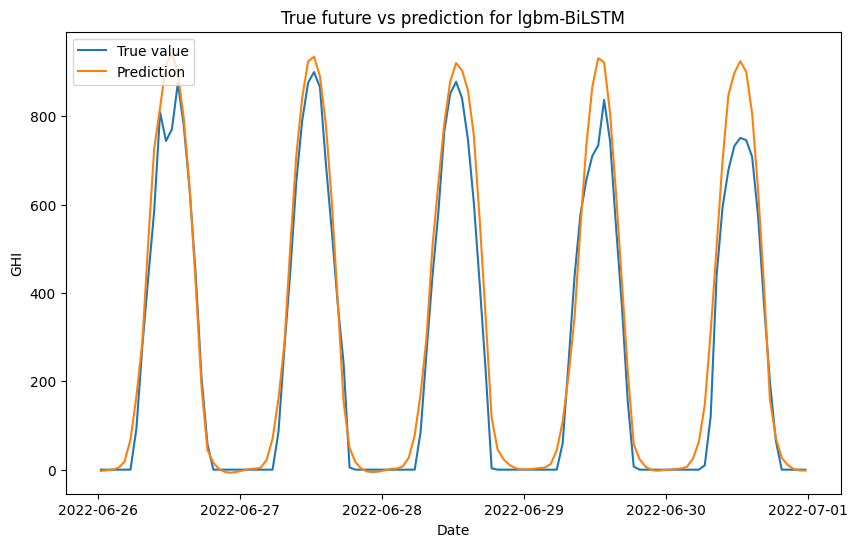

In [144]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    prediction_index = dataset.index[-range_future:]  

    plt.plot(prediction_index, np.array(y_test), label='True value')
    plt.plot(prediction_index, np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_lgbm_bilstm, 'lgbm-BiLSTM', y_test)

In [145]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, lgbm_output_train, 'lgbm', 'Training')
evaluate_model(y_testy, lgbm_output_test, 'lgbm', 'Testing')

In [146]:
evaluate_model(y_test, prediction_lgbm_bilstm, 'lgbm-BiLSTM', 'Testing')

In [147]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'lgbm-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
12,lgbm-BiLSTM,Testing,46.739968,4825.228677,69.463866,0.953402


### Results

In [148]:
def highlight_bilstm_rows(row):
  if 'BiLSTM' in row['Model']:
    return ['background-color: rgba(255, 255, 0, 0.4)'] * len(row)
  else:
    return [''] * len(row)

In [149]:
results_df = pd.DataFrame(evaluation_results)
styled_results_df = results_df.style.apply(highlight_bilstm_rows, axis=1)
print("\nevaluation metrics table: ")
styled_results_df


evaluation metrics table: 


,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Testing,41.515470,3216.695784,56.715922,0.968936
1,gbdt,Training,300.771337,110788.473531,332.849025,0.145286
2,gbdt,Testing,276.598584,90050.950760,300.084906,0.142625
3,GBDT-BiLSTM,Testing,42.611347,3855.923193,62.096080,0.962763
4,CatBoost,Training,305.340865,114193.947083,337.925949,0.119013
5,CatBoost,Testing,279.588546,91756.462549,302.913292,0.126387
6,CatBoost-BiLSTM,Testing,52.974865,6493.464605,80.582036,0.937292
7,xgb,Training,301.367013,111287.512344,333.597830,0.141436
8,xgb,Testing,278.506965,90938.981756,301.560909,0.134170
9,xgb-BiLSTM,Testing,72.138793,12218.221126,110.536063,0.882007


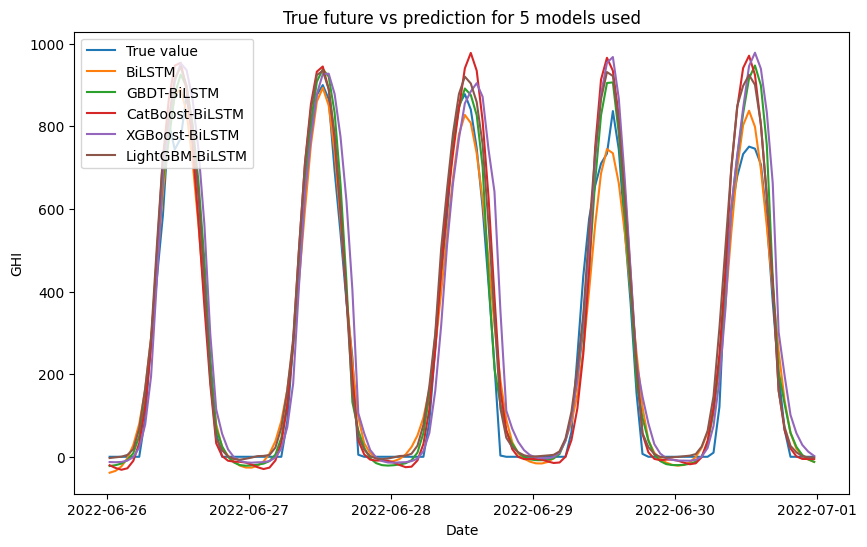

In [151]:
def plot_models_pred(pred_b, pred_gbdt, pred_cb, pred_xgb, pred_lgbm, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(pred_b)
    prediction_index = dataset.index[-range_future:]  

    plt.plot(prediction_index, np.array(y_test), label='True value')
    plt.plot(prediction_index, np.array(pred_b),label='BiLSTM')
    plt.plot(prediction_index, np.array(pred_gbdt),label='GBDT-BiLSTM')
    plt.plot(prediction_index, np.array(pred_cb),label='CatBoost-BiLSTM')
    plt.plot(prediction_index, np.array(pred_xgb),label='XGBoost-BiLSTM')
    plt.plot(prediction_index, np.array(pred_lgbm),label='LightGBM-BiLSTM')

    plt.title('True future vs prediction for 5 models used')
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')

plot_models_pred(prediction_bilstm, prediction_gbdt_bilstm, prediction_cb_bilstm, prediction_xgb_bilstm, prediction_lgbm_bilstm, y_test )